In [258]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

As for now, I plan to experiment with the entire pipeline in this notebook. As for later, more computationally heavy parts can be writte to .py files for integration with the dashboard. 

**LOAD THE DATA**

In [259]:
df_b = pd.read_parquet('../data/processed/burglaries.parquet')
df_burglaries = df_b.groupby(['Ward code', 'Month']).size().reset_index(name='Crime count')
print(df_burglaries.columns)
display(df_burglaries.head())

df_c = pd.read_parquet('../data/processed/census_lsoa.parquet')
df_census = df_c.groupby('Ward code').sum(numeric_only=True).reset_index() # sum of LSOAs in each ward
print(df_census.columns)
display(df_census.head())

df_d = pd.read_parquet('../data/processed/deprivation_lsoa.parquet')
df_deprivation = df_d.groupby('Ward code').mean(numeric_only=True).reset_index() # average of LSOAs in each ward
print(df_deprivation.columns)
display(df_deprivation)

# boundary data
gdf_ward_boundaries = gpd.read_file('../data/boundaries/ward boundaries 2024/london_wards_merged.shp')


Index(['Ward code', 'Month', 'Crime count'], dtype='object')


,Ward code,Month,Crime count
0,E05009317,2022-04-01,8
1,E05009317,2022-05-01,17
2,E05009317,2022-06-01,7
3,E05009317,2022-07-01,10
4,E05009317,2022-08-01,10


Index(['Ward code', 'Total population', 'Under 15 years', '15 to 64 years',
       '65 years and older', 'Total: All households', 'One-person household',
       'One-person household: Aged 66 years and over',
       'One-person household: Other', 'Single family household',
       'Other household types', 'Detached whole house or bungalow',
       'Semi-detached whole house or bungalow',
       'Terraced whole house or bungalow', 'Flat, maisonette or apartment',
       'A caravan or other mobile or temporary structure',
       'Total: All dwellings', 'Total: Occupied dwellings',
       'Unoccupied dwellings'],
      dtype='object')


,Ward code,Total population,Under 15 years,15 to 64 years,65 years and older,Total: All households,One-person household,One-person household: Aged 66 years and over,One-person household: Other,Single family household,Other household types,Detached whole house or bungalow,Semi-detached whole house or bungalow,Terraced whole house or bungalow,"Flat, maisonette or apartment",A caravan or other mobile or temporary structure,Total: All dwellings,Total: Occupied dwellings,Unoccupied dwellings
0,E05009317,23708,4456,17884,1368,8044.0,2260.0,454.0,1806.0,4283.0,1501.0,60.0,130.0,870.0,7410.0,0.0,8535,8030,490.0
1,E05009318,21615,3325,17514,776,9571.0,3491.0,245.0,3246.0,4708.0,1372.0,0.0,75.0,335.0,10925.0,80.0,11490,9545,1945.0
2,E05009319,19540,3228,15150,1162,8401.0,2721.0,492.0,2229.0,4398.0,1282.0,115.0,205.0,935.0,7700.0,0.0,8990,8405,580.0
3,E05009320,13708,2396,10173,1139,5277.0,1529.0,406.0,1123.0,2656.0,1092.0,50.0,165.0,1360.0,3980.0,0.0,5580,5275,305.0
4,E05009321,11567,2401,8465,701,4441.0,1418.0,208.0,1210.0,2326.0,697.0,45.0,105.0,350.0,4180.0,20.0,4725,4445,280.0


Index(['Ward code', 'Index of Multiple Deprivation (IMD) Score',
       'Index of Multiple Deprivation (IMD) Rank',
       'Index of Multiple Deprivation (IMD) Decile', 'Income Score',
       'Income Rank', 'Income Decile', 'Employment Score', 'Employment Rank',
       'Employment Decile', 'Education, Skills and Training Score',
       'Education, Skills and Training Rank',
       'Education, Skills and Training Decile',
       'Health Deprivation and Disability Score',
       'Health Deprivation and Disability Rank',
       'Health Deprivation and Disability Decile', 'Crime Score', 'Crime Rank',
       'Crime Decile', 'Barriers to Housing and Services Score',
       'Barriers to Housing and Services Rank',
       'Barriers to Housing and Services Decile', 'Living Environment Score',
       'Living Environment Rank', 'Living Environment Decile'],
      dtype='object')


,Ward code,Index of Multiple Deprivation (IMD) Score,Index of Multiple Deprivation (IMD) Rank,Index of Multiple Deprivation (IMD) Decile,Income Score,Income Rank,Income Decile,Employment Score,Employment Rank,Employment Decile,...,Health Deprivation and Disability Decile,Crime Score,Crime Rank,Crime Decile,Barriers to Housing and Services Score,Barriers to Housing and Services Rank,Barriers to Housing and Services Decile,Living Environment Score,Living Environment Rank,Living Environment Decile
0,E05009317,29.618149,8591.484596,3.216929,0.202229,7069.749127,2.800262,0.111058,12027.812847,4.100524,...,4.300262,0.667665,8068.050580,3.150786,29.623605,7349.157218,2.616405,36.876296,6322.995315,2.449738
1,E05009318,18.023071,16578.071429,5.785714,0.109071,16913.357143,5.642857,0.057786,23493.785714,7.714286,...,5.857143,-0.327929,21006.857143,6.857143,31.674429,6185.071429,2.214286,35.877000,8329.000000,3.000000
2,E05009319,28.217091,9341.909091,3.363636,0.178818,9415.454545,3.090909,0.096455,15163.000000,5.090909,...,3.545455,0.667545,7742.181818,3.000000,31.129636,6525.272727,2.545455,36.264818,8681.636364,3.090909
3,E05009320,26.289714,10240.428571,3.714286,0.170143,9800.571429,3.571429,0.097000,14078.000000,4.714286,...,5.000000,1.017714,4709.000000,2.142857,26.295000,10085.714286,3.428571,34.832857,7237.000000,2.714286
4,E05009321,34.337286,6293.285714,2.571429,0.252143,4005.000000,1.714286,0.139286,7853.142857,2.857143,...,4.142857,0.837286,6704.142857,2.714286,30.805286,6611.428571,2.571429,29.484000,9706.000000,3.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,E05014116,19.240600,15450.200000,5.000000,0.118000,14961.000000,5.200000,0.078200,18283.000000,6.200000,...,6.400000,0.131000,14636.200000,5.000000,26.793600,9656.800000,3.400000,41.952800,4070.800000,1.600000
676,E05014117,29.338286,8884.000000,3.142857,0.166000,9948.428571,3.428571,0.107857,12572.285714,4.285714,...,4.285714,0.523857,9047.571429,3.285714,32.303143,5578.285714,2.142857,55.116714,1719.142857,1.142857
677,E05014118,20.963200,14518.600000,5.000000,0.099800,18307.400000,6.200000,0.063800,21093.000000,6.600000,...,4.800000,0.258600,13397.400000,4.400000,29.860800,7241.200000,2.600000,52.309000,2965.400000,1.400000
678,E05014119,20.499800,15804.800000,5.200000,0.121800,16304.200000,5.600000,0.084000,18486.200000,6.200000,...,6.800000,0.502600,9286.400000,3.400000,26.530800,10132.800000,3.800000,40.291600,4424.400000,1.800000


In [260]:
# merge all data
df_ward_features = (
    df_burglaries
    .merge(df_census, on="Ward code")
    .merge(df_deprivation, on="Ward code")
)

# add normalized crime columns
df_ward_features["Crimes per 1,000 people"] = (df_ward_features["Crime count"] / df_ward_features["Total population"]) * 1000
df_ward_features["Crimes per 1,000 dwellings"] = (df_ward_features["Crime count"] / df_ward_features["Total: All dwellings"]) * 1000
df_ward_features["Crimes per 1,000 households"] = (
    df_ward_features["Crime count"] / df_ward_features["Total: All households"]
) * 1000


**EXPLARATORY DATA ANALYSIS**

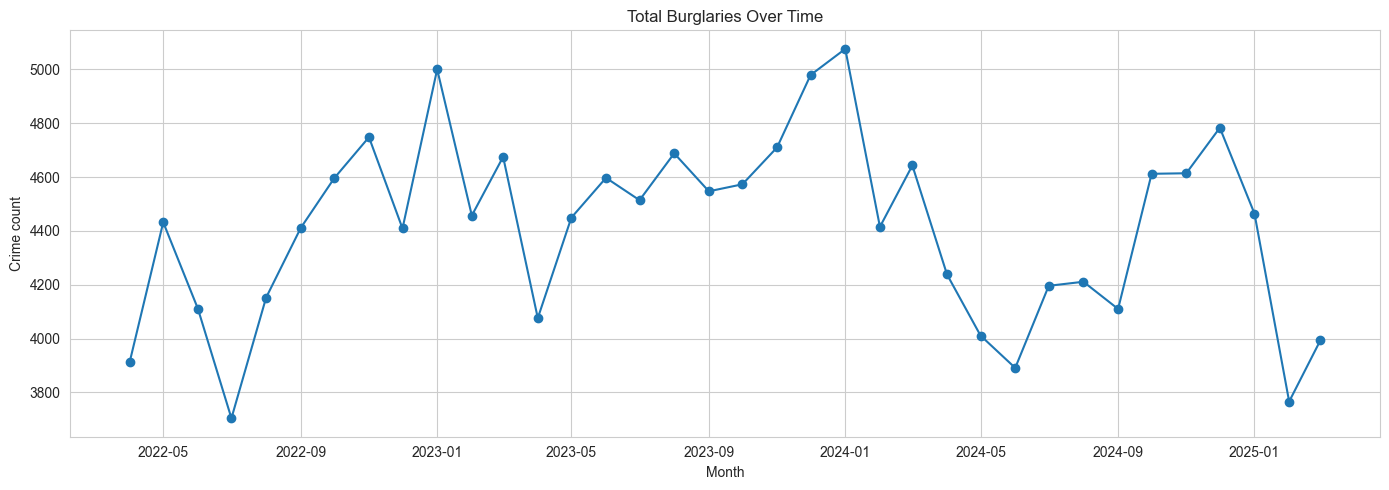

'There seems to be seasonality, although it is rather irregular. Most prominent are the peaks around December/January.'

In [261]:
# TOTAL BURGLARIES OVER TIME

df_burglaries_over_time = df_burglaries.groupby("Month")["Crime count"].sum().reset_index()

# plot
plt.figure(figsize=(14, 5))
plt.plot(df_burglaries_over_time["Month"], df_burglaries_over_time["Crime count"], marker='o')
plt.title("Total Burglaries Over Time")
plt.xlabel("Month")
plt.ylabel("Crime count")
plt.grid(True)
plt.tight_layout()
plt.show()


'There seems to be seasonality, although it is rather irregular. Most prominent are the peaks around December/January.'

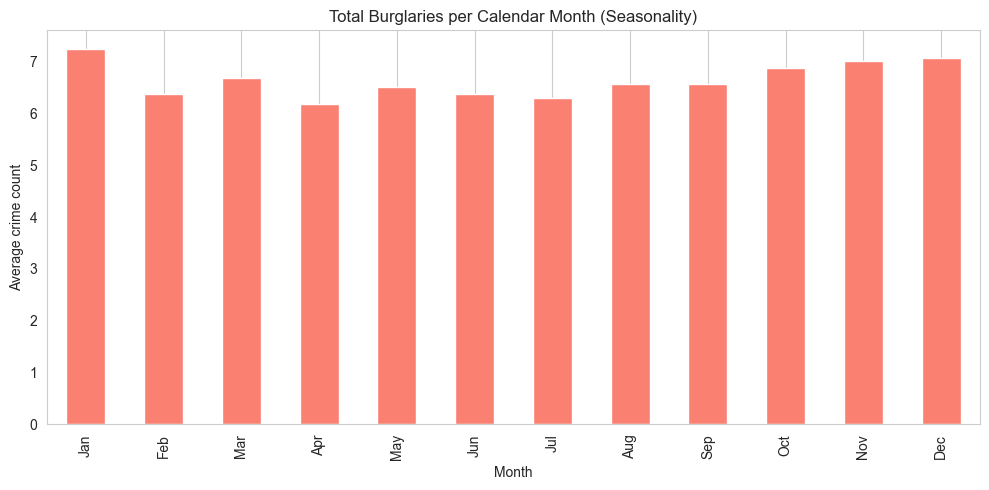

'The differences do not seem too pronounced, but generally colder months in autumn/winter such as November, December, January show higher crime counts compared to months in the summer such as June and July.'

In [262]:
# CRIMES BY MONTH OF YEAR

# Extract month name or number
df_burglaries["Month_num"] = df_burglaries["Month"].dt.month
df_burglaries["Month_name"] = df_burglaries["Month"].dt.strftime('%b')

# Average crime per calendar month
df_seasonality = (
    df_burglaries.groupby("Month_name")["Crime count"]
    .mean()
    .reindex(["Jan", "Feb", "Mar", "Apr", "May", "Jun",
              "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
)

# Plot
plt.figure(figsize=(10, 5))
df_seasonality.plot(kind="bar", color="salmon")
plt.title("Total Burglaries per Calendar Month (Seasonality)")
plt.ylabel("Average crime count")
plt.xlabel("Month")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


'The differences do not seem too pronounced, but generally colder months in autumn/winter such as November, December, January show higher crime counts compared to months in the summer such as June and July.'


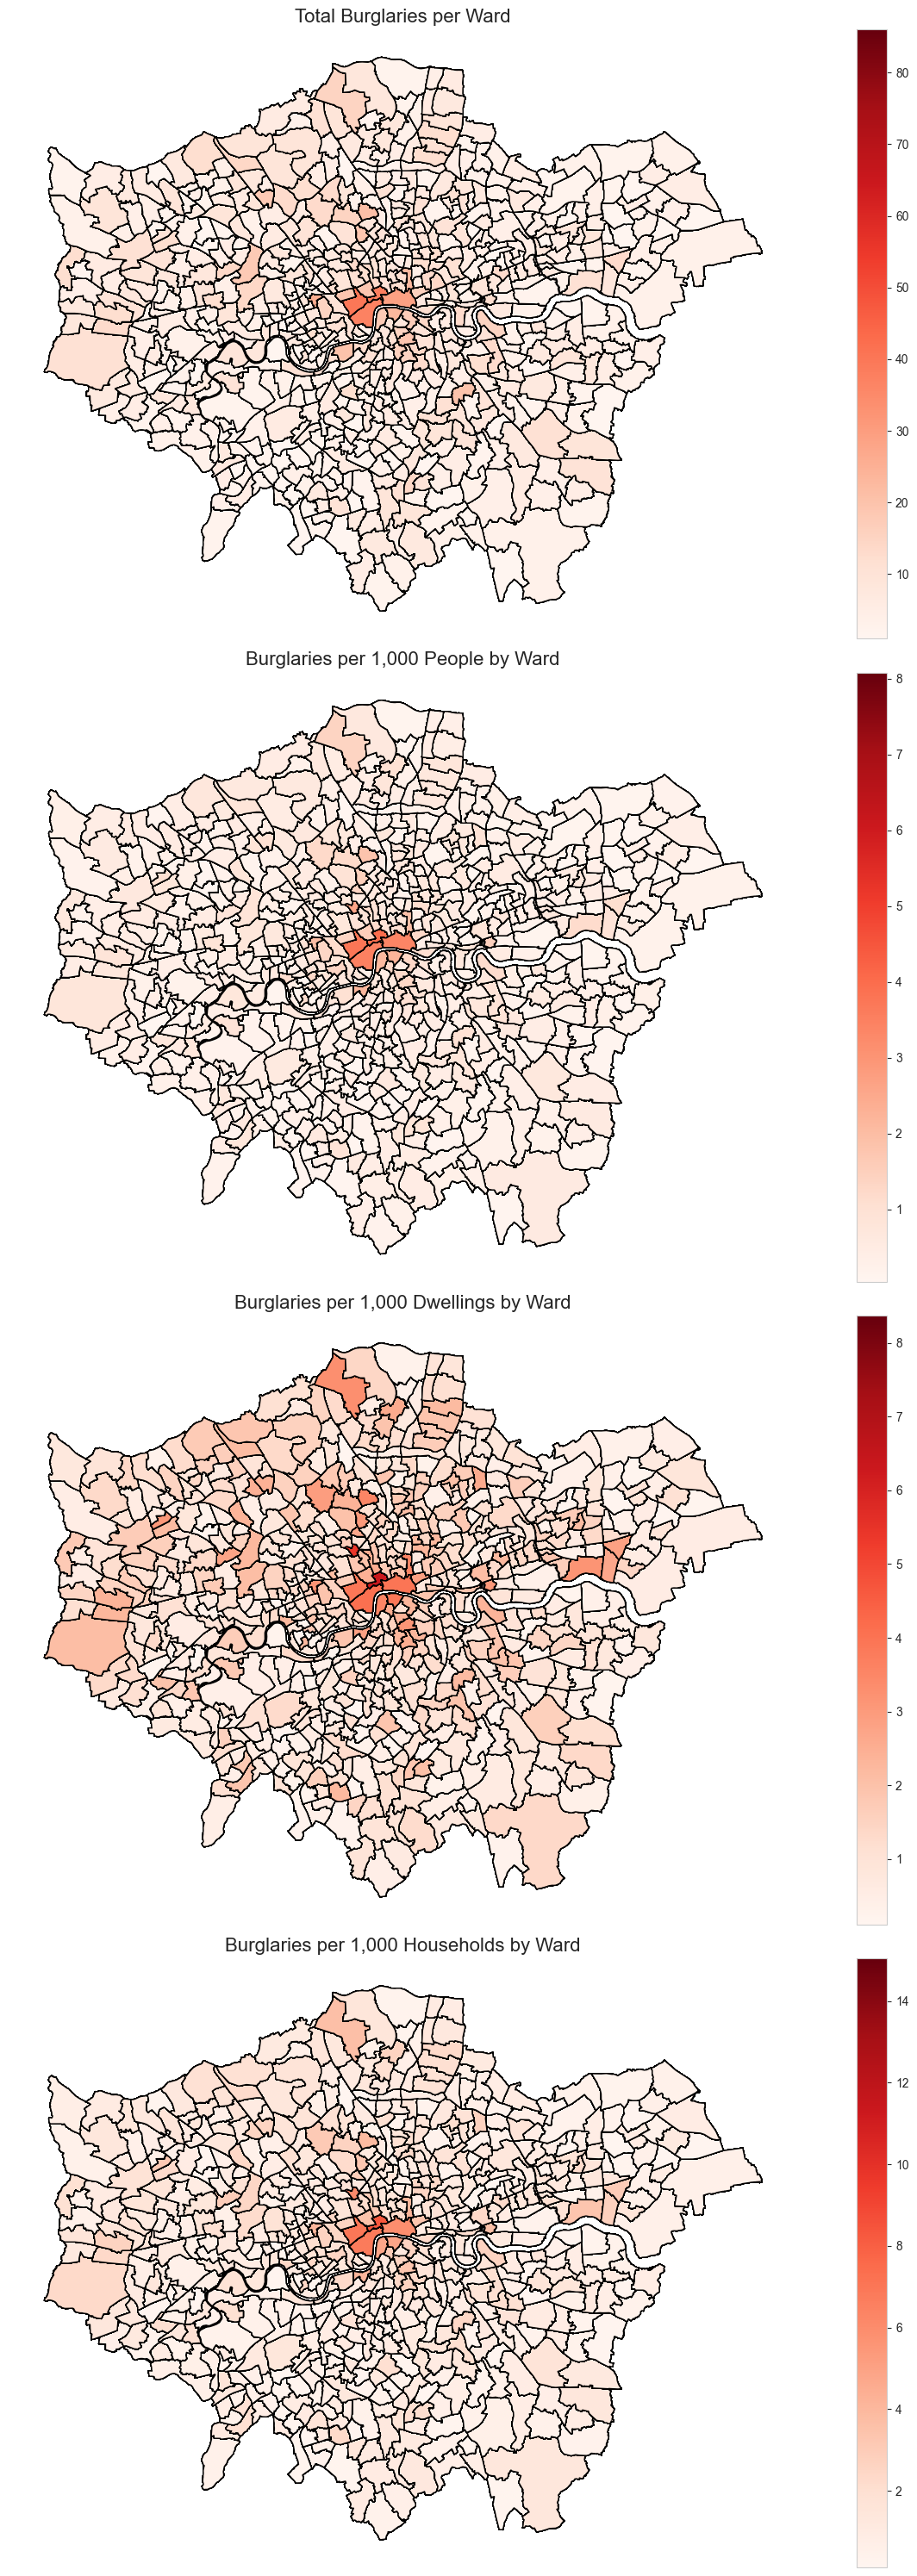

'There is minimal difference when normalizing by total population or the number of households, the biggest difference is observed for the number of dwellings. I suggest normalizing by the number of dwellings or by the number of households, as burglaries are often targeted at dwellings/households, but we can choose any one of these 4.'

In [263]:
# (NORMALIZED) CRIME RATES PER WARD 

# Merge with GeoDataFrame
gdf_crime_rates = gdf_ward_boundaries.merge(df_ward_features, left_on='WD24CD', right_on="Ward code", how="left")

# Create figure and axes
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 30))

# Plot 1: Total Crimes
gdf_crime_rates.plot(
    column="Crime count", ax=axes[0], legend=True,
    cmap="Reds", edgecolor="black"
)
axes[0].set_title("Total Burglaries per Ward", fontsize=16)
axes[0].axis("off")

# Plot 2: Crimes per 1,000 People
gdf_crime_rates.plot(
    column="Crimes per 1,000 people", ax=axes[1], legend=True,
    cmap="Reds", edgecolor="black"
)
axes[1].set_title("Burglaries per 1,000 People by Ward", fontsize=16)
axes[1].axis("off")

# Plot 3: Crimes per 1,000 dwellings
gdf_crime_rates.plot(
    column="Crimes per 1,000 dwellings", ax=axes[2], legend=True,
    cmap="Reds", edgecolor="black"
)
axes[2].set_title("Burglaries per 1,000 Dwellings by Ward", fontsize=16)
axes[2].axis("off")

# Plot 4: Crimes per 1,000 households
gdf_crime_rates.plot(
    column="Crimes per 1,000 households", ax=axes[3], legend=True,
    cmap="Reds", edgecolor="black"
)
axes[3].set_title("Burglaries per 1,000 Households by Ward", fontsize=16)
axes[3].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

'There is minimal difference when normalizing by total population or the number of households, the biggest difference is observed for the number of dwellings. I suggest normalizing by the number of dwellings or by the number of households, as burglaries are often targeted at dwellings/households, but we can choose any one of these 4.'

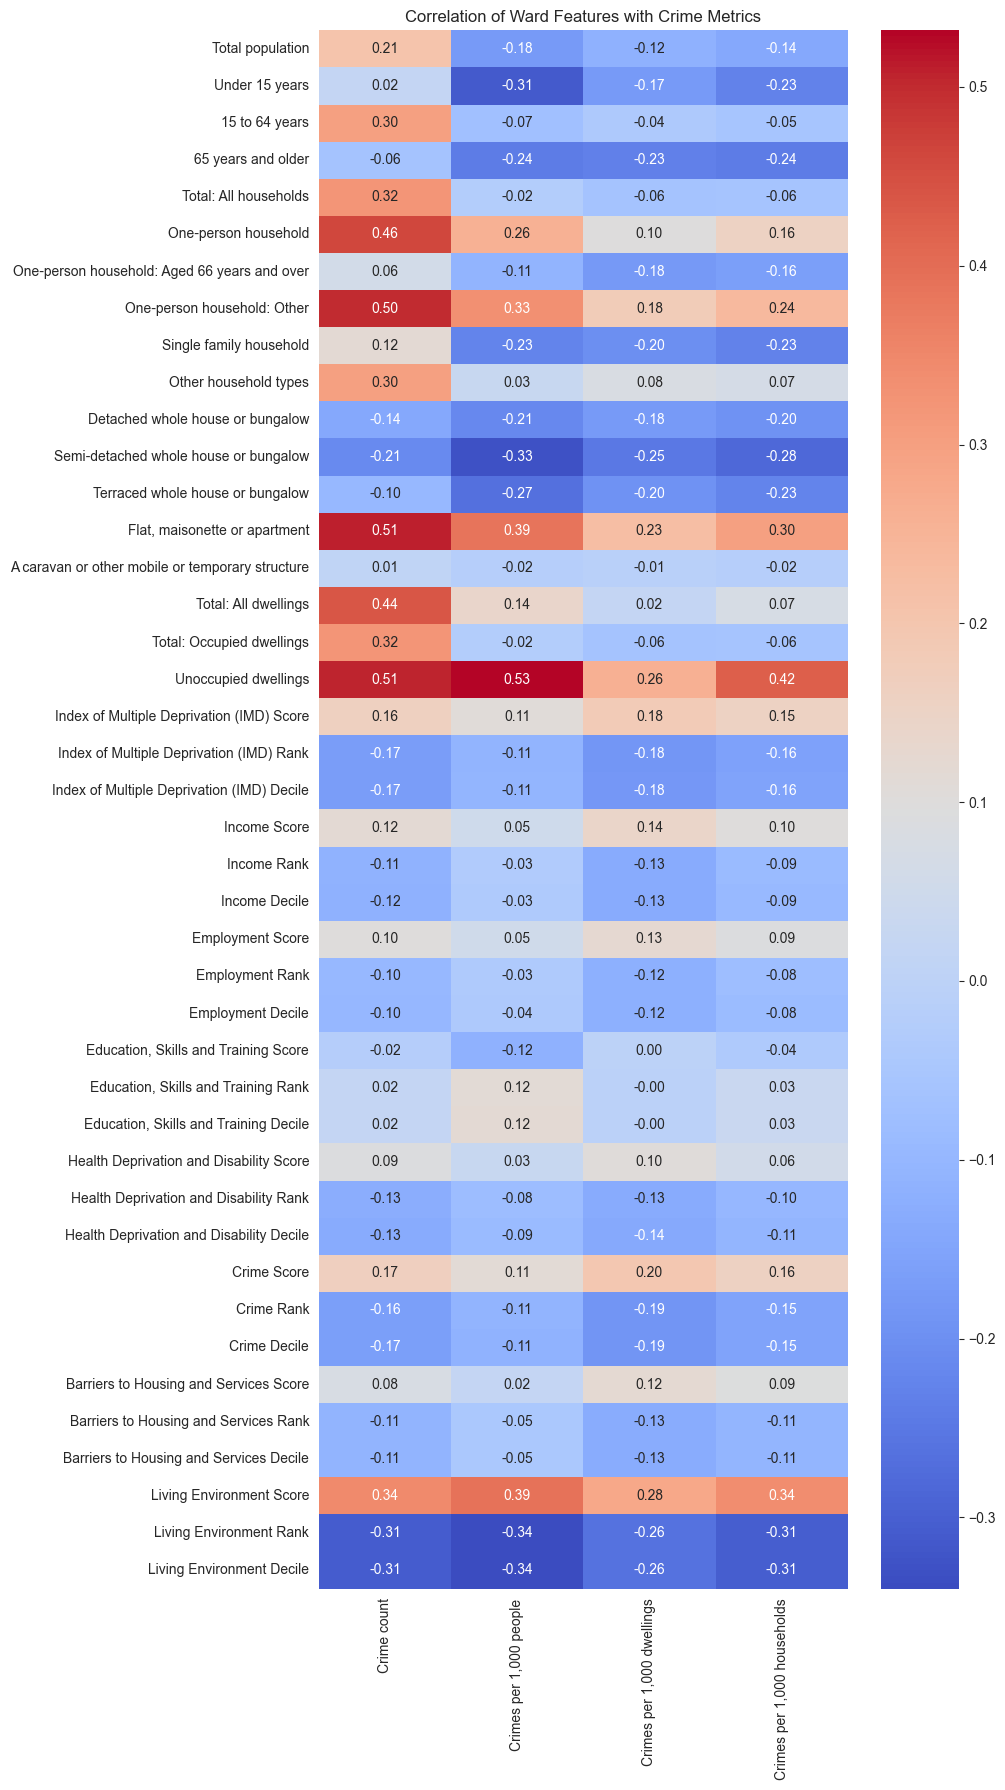

In [264]:
# CORRELATION MATRIX

# Select only numeric columns
numeric_data = df_ward_features.select_dtypes(include="number")

# Compute correlation matrix
corr_matrix = numeric_data.corr()

# Focus only on correlations with crime metrics
target_vars = ["Crime count", "Crimes per 1,000 people", "Crimes per 1,000 dwellings", "Crimes per 1,000 households"]
crime_corr = corr_matrix[target_vars].drop(index=target_vars)

# Plot heatmap
plt.figure(figsize=(10, 18))
sns.heatmap(crime_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation of Ward Features with Crime Metrics")
plt.tight_layout()
plt.show()


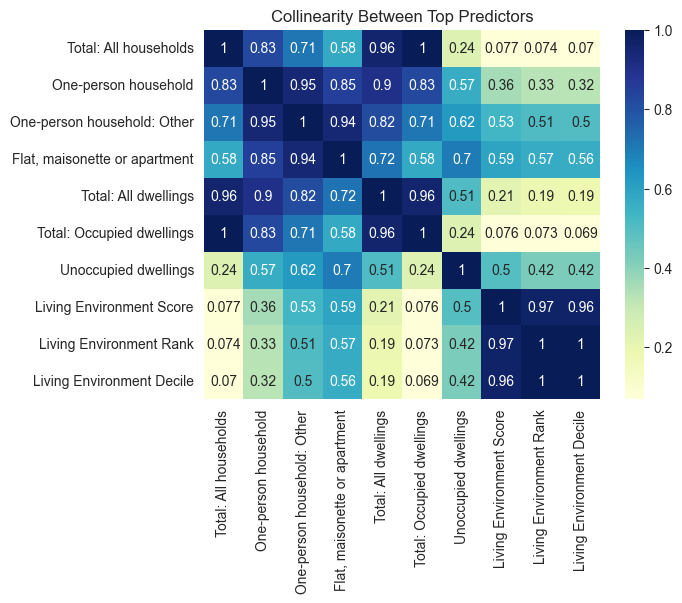

In [265]:
# CORRELATION BETWEEN MOST PROMISING PREDICTORS

# Compute correlation between predictors only
feature_corr = numeric_data.drop(columns=target_vars).corr().abs()

# Mask self-correlations
upper = feature_corr.where(np.triu(np.ones(feature_corr.shape), k=1).astype(bool))

# Find pairs with high collinearity
high_corr_pairs = [(col, row) for col in upper.columns for row in upper.index if upper.loc[row, col] > 0.85]

# 1. Filter by correlation with crime (e.g., abs(corr) > 0.3)
target = "Crime count"  
top_feats = crime_corr[abs(crime_corr[target]) > 0.3].index.tolist()

# 2. Check collinearity among top features
corr_subset = df_ward_features[top_feats].corr().abs()

# 3. Drop redundant features (manually or programmatically)
sns.heatmap(corr_subset, annot=True, cmap='YlGnBu')
plt.title("Collinearity Between Top Predictors")
plt.show()



Plan is to first keep all features, then use SHAP or XGBoost.feature_importance to prune later, ensuring interpretability. However, the most obvious collinear pairs will be removed: for indices of deprivation metrics, keep only the score and not rank/decile. 

**EXPLORATION FEATURE ENGINEERING** 

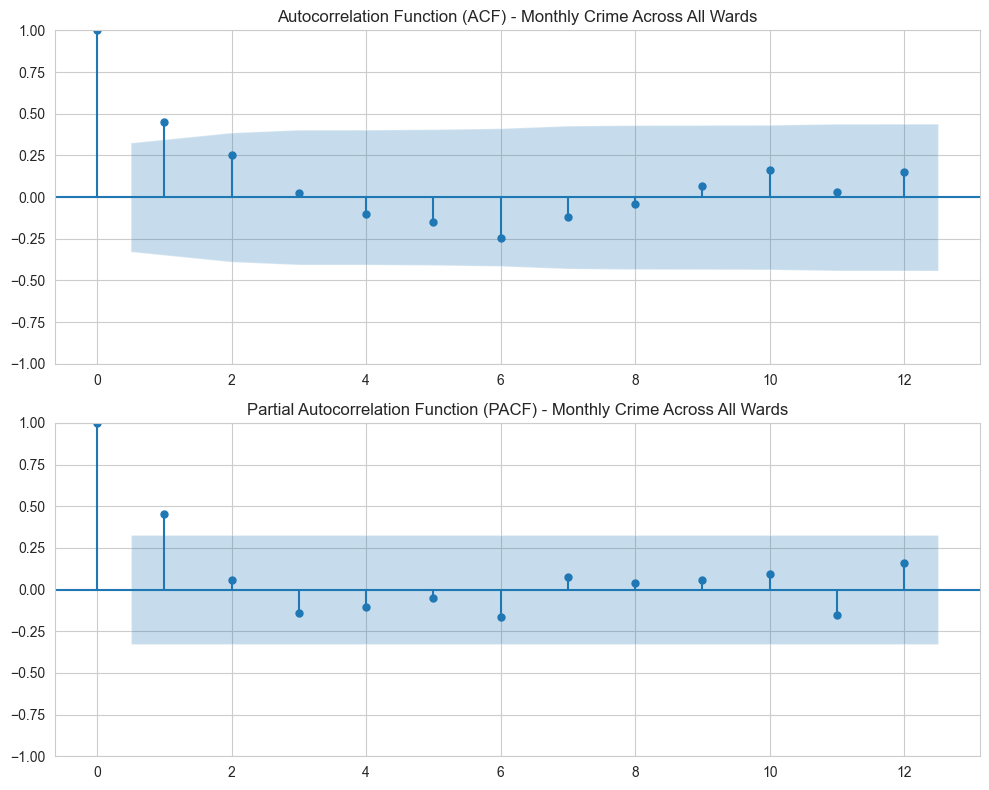

'Only the first lag appears significant to include in the model. However, I can try to experiment with up to lag 6. I do not think we should go beyond that, because of little data.'

In [266]:
# VISUALIZE LAGS

# aggregate globally (sum over wards for each year-month)
burglaries_ts = df_burglaries.groupby("Month")["Crime count"].sum().sort_index()

# ACF and PACF for global monthly series
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(burglaries_ts, lags=12, ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF) - Monthly Crime Across All Wards")

plot_pacf(burglaries_ts, lags=12, ax=ax[1], method="ywm")
ax[1].set_title("Partial Autocorrelation Function (PACF) - Monthly Crime Across All Wards")

plt.tight_layout()
plt.show()

'Only the first lag appears significant to include in the model. However, I can try to experiment with up to lag 6. I do not think we should go beyond that, because of little data.'


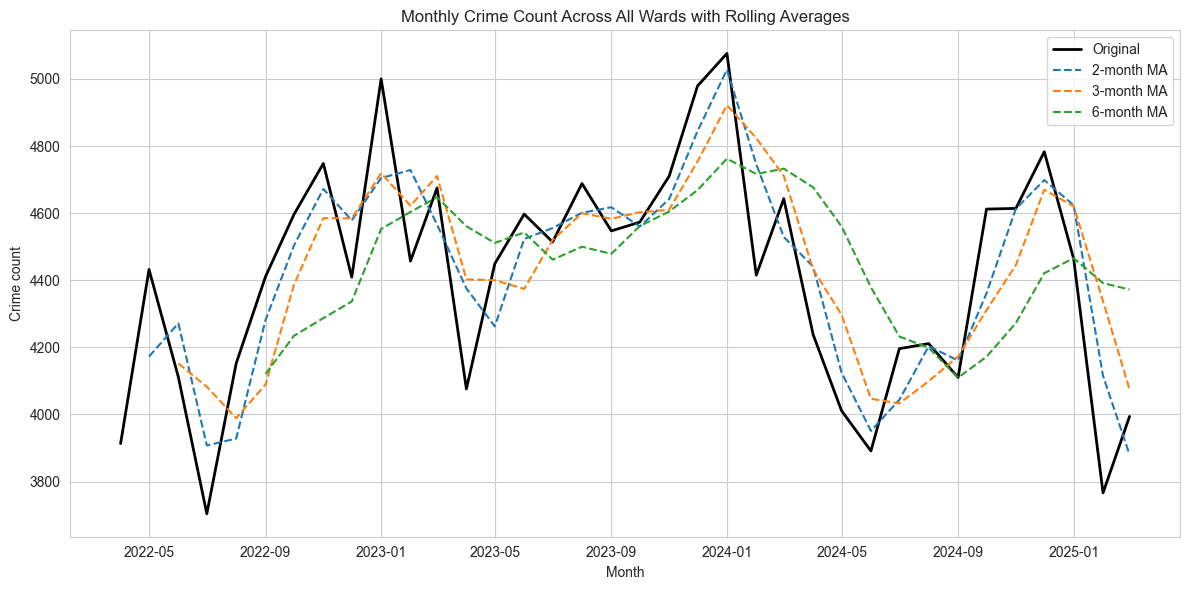

'We already do not have a lot of data, so we should not have a large window for moving average (if we include it at all). I think I can maybe try with moving average up to 6 for now.'

In [267]:
# VISUALIZE ROLLING AVERAGES

# Rolling averages
rolling_2 = burglaries_ts.rolling(window=2).mean()
rolling_3 = burglaries_ts.rolling(window=3).mean()
rolling_6 = burglaries_ts.rolling(window=6).mean()

# Plot all
plt.figure(figsize=(12, 6))
plt.plot(burglaries_ts, label="Original", color="black", linewidth=2)
plt.plot(rolling_2, label="2-month MA", linestyle="--")
plt.plot(rolling_3, label="3-month MA", linestyle="--")
plt.plot(rolling_6, label="6-month MA", linestyle="--")

plt.title("Monthly Crime Count Across All Wards with Rolling Averages")
plt.xlabel("Month")
plt.ylabel("Crime count")
plt.legend()
plt.tight_layout()
plt.show()

'We already do not have a lot of data, so we should not have a large window for moving average (if we include it at all). I think I can maybe try with moving average up to 6 for now.'


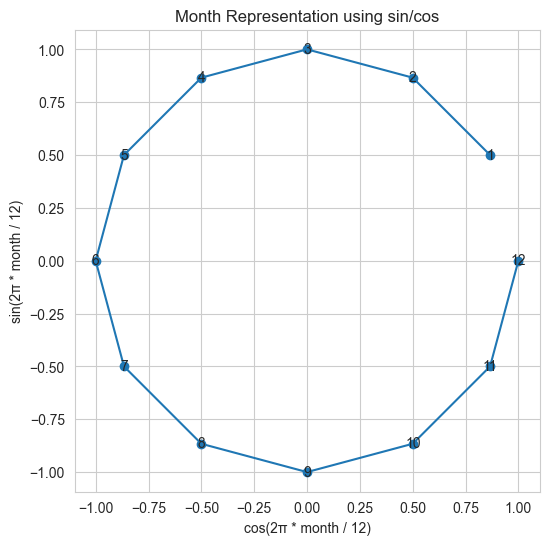

'I will experiment using month sin/cos for a more cyclical interpretation and separate dummies for each month.'

In [268]:
# MONTH REPRESENTATION USING SIN/COS. ALTERNATIVE IS TO ENCODE EACH MONTH AS CATEGORICAL (which I will also experiment with, and see which has higher performance. 
months = np.arange(1, 13)
month_sin = np.sin(2 * np.pi * months / 12)
month_cos = np.cos(2 * np.pi * months / 12)

plt.figure(figsize=(6, 6))
plt.plot(month_cos, month_sin, marker='o')
for i, m in enumerate(months, 1):
    plt.text(month_cos[i-1], month_sin[i-1], str(m), ha='center', va='center')
plt.title("Month Representation using sin/cos")
plt.xlabel("cos(2π * month / 12)")
plt.ylabel("sin(2π * month / 12)")
plt.grid(True)
plt.axis("equal")
plt.show()

'I will experiment using month sin/cos for a more cyclical interpretation and separate dummies for each month.'


In [269]:
# CHECK STATIONARITY: WHETHER TO DIFFERENCE

# Apply Augmented Dickey-Fuller test
adf_result = adfuller(burglaries_ts)

# Display results
print("ADF Statistic:", round(adf_result[0], 4))
print("p-value:", round(adf_result[1], 4))
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {round(value, 4)}")

if adf_result[1] < 0.05:
    print("\nThe time series is likely stationary (p < 0.05).")
else:
    print("\nThe time series is likely non-stationary (p ≥ 0.05).")
    
'Based on this, I do not think including first difference is necessary.'


ADF Statistic: -3.4928
p-value: 0.0082
Critical Value (1%): -3.6327
Critical Value (5%): -2.9485
Critical Value (10%): -2.613

The time series is likely stationary (p < 0.05).


'Based on this, I do not think including first difference is necessary.'

**GLOBAL XGBOOST WITH ONLY BURGLARY TIME SERIES**

In [270]:
def create_temporal_features(df, lags=[1], rolling_window=None, month_encoding="sin_cos"):
    df = df.copy()
    df["Month"] = pd.to_datetime(df["Month"])
    df.sort_values(["Ward code", "Month"], inplace=True)
    df["month_num"] = df["Month"].dt.month

    # Month encoding
    if month_encoding == "sin_cos":
        df["month_sin"] = np.sin(2 * np.pi * df["month_num"] / 12)
        df["month_cos"] = np.cos(2 * np.pi * df["month_num"] / 12)
        df.drop(columns=["month_num"], inplace=True)
    elif month_encoding == "one_hot":
        dummies = pd.get_dummies(df["month_num"], prefix="month")
        df = pd.concat([df, dummies], axis=1)
        df.drop(columns=["month_num"], inplace=True)

    # Lag features
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby("Ward code")["Crime count"].shift(lag)

    # Rolling average
    if rolling_window:
        df[f"rolling_mean_{rolling_window}"] = (
            df.groupby("Ward code")["Crime count"]
            .shift(1)
            .rolling(rolling_window)
            .mean()
        )
    
    # Ward code as category
    df["Ward code"] = df["Ward code"].astype("category")


    df.dropna(inplace=True)
    return df


In [271]:
def temporal_train_test_split(df, test_months=6):
    months = df["Month"].sort_values().unique()
    split_point = months[-test_months]
    train_df = df[df["Month"] < split_point]
    test_df = df[df["Month"] >= split_point]
    return train_df, test_df


In [272]:
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb

def train_and_evaluate(train_df, test_df, features):
    X_train = train_df[features]
    y_train = train_df["Crime count"]
    X_test = test_df[features]
    y_test = test_df["Crime count"]

    model = xgb.XGBRegressor(enable_categorical=True, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, preds)
    return rmse, model


In [273]:
# LOOP THROUGH DIFFERENT CONFIGURATIONS

import itertools
import pandas as pd

# Generate all non-empty combinations of lags from 1 to 6
lag_pool = [1, 2, 3, 4, 5, 6]
lag_options = []

for r in range(1, len(lag_pool) + 1):
    lag_options.extend(list(itertools.combinations(lag_pool, r)))

# Convert to list of lists
lag_options = [list(lag) for lag in lag_options]

# Other parameters
rolling_options = [None, 2, 3, 4, 5, 6]
month_encodings = ["sin_cos", "one_hot"]

# Cartesian product of all configurations
experiments = list(itertools.product(lag_options, rolling_options, month_encodings))
results = []

for i, (lags, rolling_window, month_encoding) in enumerate(experiments):
    print(f"\nRunning Experiment {i+1}/{len(experiments)}")
    print(f"Lags: {lags}, Rolling: {rolling_window}, Month Encoding: {month_encoding}")
    
    df_features = create_temporal_features(df_burglaries, lags=lags,
                                           rolling_window=rolling_window,
                                           month_encoding=month_encoding)
    
    feature_cols = [col for col in df_features.columns if col.startswith("lag_") or
                    col.startswith("rolling") or col.startswith("month_")] + ["Ward code"]

    train_df, test_df = temporal_train_test_split(df_features, test_months=4)
    rmse, model = train_and_evaluate(train_df, test_df, feature_cols)

    results.append({
        "Experiment": i + 1,
        "Lags": lags,
        "Rolling": rolling_window,
        "Month Encoding": month_encoding,
        "RMSE": rmse
    })
    print(f"RMSE: {rmse:.2f}")


# Convert and sort results
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="RMSE", na_position="last").reset_index(drop=True)

# Display
pd.set_option("display.max_colwidth", None)
display(results_df_sorted)



Running Experiment 1/756
Lags: [1], Rolling: None, Month Encoding: sin_cos
RMSE: 3.92

Running Experiment 2/756
Lags: [1], Rolling: None, Month Encoding: one_hot
RMSE: 3.93

Running Experiment 3/756
Lags: [1], Rolling: 2, Month Encoding: sin_cos
RMSE: 3.88

Running Experiment 4/756
Lags: [1], Rolling: 2, Month Encoding: one_hot
RMSE: 3.87

Running Experiment 5/756
Lags: [1], Rolling: 3, Month Encoding: sin_cos
RMSE: 3.89

Running Experiment 6/756
Lags: [1], Rolling: 3, Month Encoding: one_hot
RMSE: 3.90

Running Experiment 7/756
Lags: [1], Rolling: 4, Month Encoding: sin_cos
RMSE: 3.88

Running Experiment 8/756
Lags: [1], Rolling: 4, Month Encoding: one_hot
RMSE: 3.95

Running Experiment 9/756
Lags: [1], Rolling: 5, Month Encoding: sin_cos
RMSE: 3.93

Running Experiment 10/756
Lags: [1], Rolling: 5, Month Encoding: one_hot
RMSE: 3.89

Running Experiment 11/756
Lags: [1], Rolling: 6, Month Encoding: sin_cos
RMSE: 3.92

Running Experiment 12/756
Lags: [1], Rolling: 6, Month Encoding: on

,Experiment,Lags,Rolling,Month Encoding,RMSE
0,583,"[1, 3, 4, 6]",4.0,sin_cos,3.765236
1,565,"[1, 3, 4, 5]",NaN,sin_cos,3.782759
2,727,"[1, 3, 4, 5, 6]",4.0,sin_cos,3.784055
3,314,"[1, 3, 5]",NaN,one_hot,3.790993
4,571,"[1, 3, 4, 5]",4.0,sin_cos,3.796305
...,...,...,...,...,...
751,170,"[2, 6]",NaN,one_hot,4.087010
752,14,[2],NaN,one_hot,4.092443
753,62,[6],NaN,one_hot,4.095408
754,146,"[2, 4]",NaN,one_hot,4.103843


In [274]:
# GET BEST EXPERIMENT CONFIGURATION

# Get best experiment config
best_config = results_df_sorted.iloc[0]
print("Best configuration:\n", best_config)

# Recreate features using best config
best_lags = best_config["Lags"]
best_rolling = int(best_config["Rolling"])
if pd.isna(best_rolling):
    best_rolling = None
best_month_encoding = best_config["Month Encoding"]


df_features = create_temporal_features(df_burglaries, lags=best_lags,
                                       rolling_window=best_rolling,
                                       month_encoding=best_month_encoding)

feature_cols = [col for col in df_features.columns if col.startswith("lag_") or
                col.startswith("rolling") or col.startswith("month_")] + ["Ward code"]

train_df, test_df = temporal_train_test_split(df_features, test_months=4)
rmse, final_model = train_and_evaluate(train_df, test_df, feature_cols)

Best configuration:
 Experiment                 583
Lags              [1, 3, 4, 6]
Rolling                    4.0
Month Encoding         sin_cos
RMSE                  3.765236
Name: 0, dtype: object


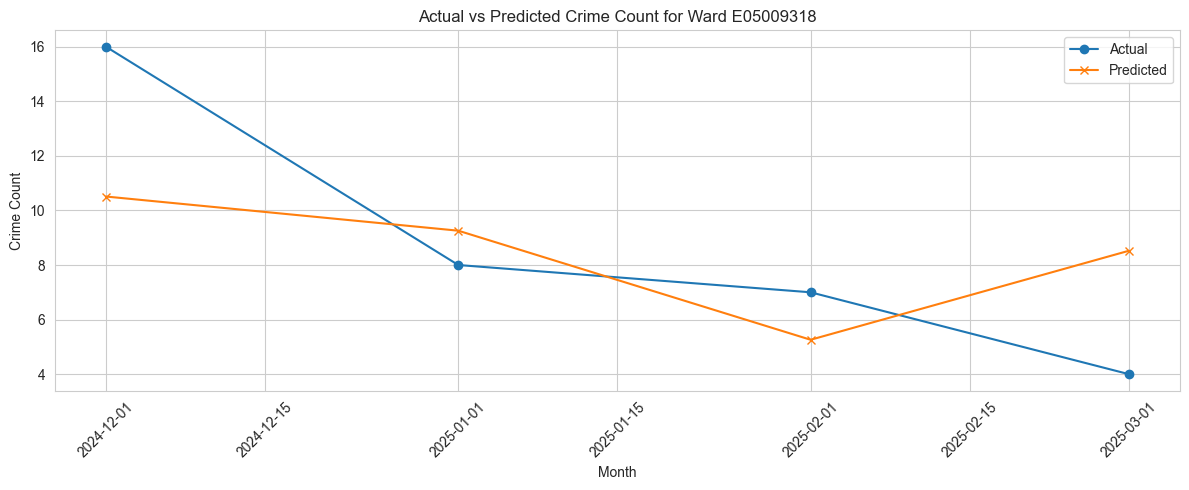

In [275]:
# PLOT TRUE VS PREDICTED CRIME COUNTS FOR EXAMPLE WARD 
test_df = test_df.copy()
test_df["prediction"] = final_model.predict(test_df[feature_cols])

# Pick a specific ward to visualize

ward_to_plot = test_df["Ward code"].unique()[1]  # replace with preferred ward if needed
ward_df = test_df[test_df["Ward code"] == ward_to_plot].sort_values("Month")

plt.figure(figsize=(12, 5))
plt.plot(ward_df["Month"], ward_df["Crime count"], label="Actual", marker='o')
plt.plot(ward_df["Month"], ward_df["prediction"], label="Predicted", marker='x')
plt.title(f"Actual vs Predicted Crime Count for Ward {ward_to_plot}")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


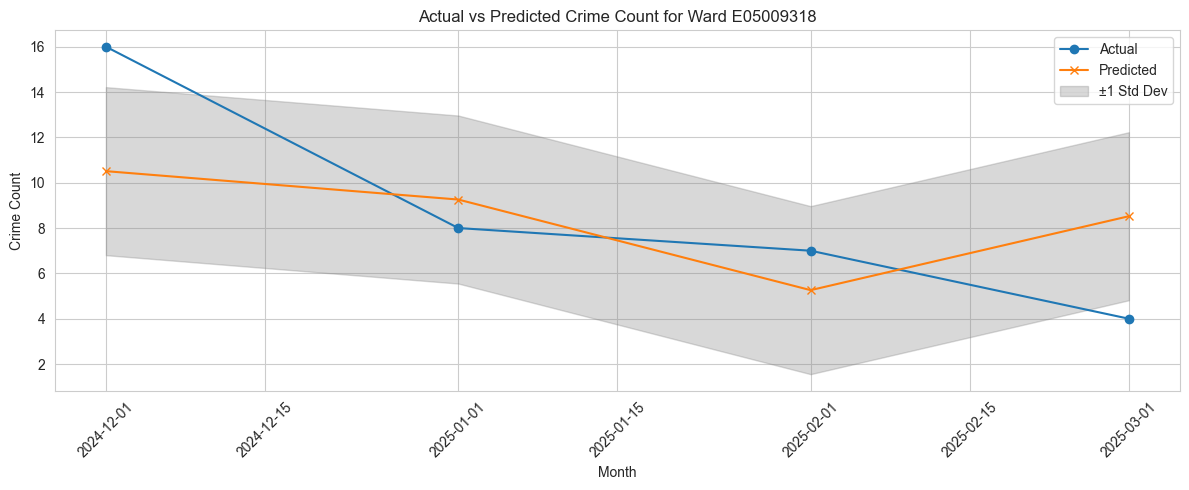

'Here, I chose an exceptionally good predicted ward. For others wards, it may be way off.'

In [276]:
# WITH MANUALLY CALCULATED RESIDUALS

import numpy as np

# Calculate residuals on the test set
residuals = test_df["Crime count"] - test_df["prediction"]

# Calculate standard deviation of residuals (error)
std_resid = np.std(residuals)

# Prepare plot
plt.figure(figsize=(12, 5))
plt.plot(ward_df["Month"], ward_df["Crime count"], label="Actual", marker='o')
plt.plot(ward_df["Month"], ward_df["prediction"], label="Predicted", marker='x')

# Add shaded area for ±1 standard deviation around predictions
plt.fill_between(
    ward_df["Month"],
    ward_df["prediction"] - std_resid,
    ward_df["prediction"] + std_resid,
    color='gray',
    alpha=0.3,
    label="±1 Std Dev"
)

plt.title(f"Actual vs Predicted Crime Count for Ward {ward_to_plot}")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

'Here, I chose an exceptionally good predicted ward. For others wards, it may be way off.'

**GLOBAL XGBOOST WITH ADDITIONAL STATIC FEATURES**

In [277]:
# INCLUDE STATIC FEATURES

# for deprivation, include only 'score'
df_deprivation_filtered = df_deprivation.loc[:, df_deprivation.columns.str.contains('Score|Ward code')]

static_features = df_census.merge(df_deprivation_filtered, on="Ward code")

df_all_features = df_burglaries.merge(static_features, on="Ward code")

display(df_all_features)


,Ward code,Month,Crime count,Month_num,Month_name,Total population,Under 15 years,15 to 64 years,65 years and older,Total: All households,...,Total: Occupied dwellings,Unoccupied dwellings,Index of Multiple Deprivation (IMD) Score,Income Score,Employment Score,"Education, Skills and Training Score",Health Deprivation and Disability Score,Crime Score,Barriers to Housing and Services Score,Living Environment Score
0,E05009317,2022-04-01,8,4,Apr,23708,4456,17884,1368,8044.0,...,8030,490.0,29.618149,0.202229,0.111058,18.296646,0.238489,0.667665,29.623605,36.876296
1,E05009317,2022-05-01,17,5,May,23708,4456,17884,1368,8044.0,...,8030,490.0,29.618149,0.202229,0.111058,18.296646,0.238489,0.667665,29.623605,36.876296
2,E05009317,2022-06-01,7,6,Jun,23708,4456,17884,1368,8044.0,...,8030,490.0,29.618149,0.202229,0.111058,18.296646,0.238489,0.667665,29.623605,36.876296
3,E05009317,2022-07-01,10,7,Jul,23708,4456,17884,1368,8044.0,...,8030,490.0,29.618149,0.202229,0.111058,18.296646,0.238489,0.667665,29.623605,36.876296
4,E05009317,2022-08-01,10,8,Aug,23708,4456,17884,1368,8044.0,...,8030,490.0,29.618149,0.202229,0.111058,18.296646,0.238489,0.667665,29.623605,36.876296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23865,E09000001,2024-11-01,21,11,Nov,8587,580,6797,1210,4915.0,...,4915,2410.0,14.805000,0.062667,0.050833,5.363500,-0.670500,-1.660833,36.271333,40.370167
23866,E09000001,2024-12-01,25,12,Dec,8587,580,6797,1210,4915.0,...,4915,2410.0,14.805000,0.062667,0.050833,5.363500,-0.670500,-1.660833,36.271333,40.370167
23867,E09000001,2025-01-01,27,1,Jan,8587,580,6797,1210,4915.0,...,4915,2410.0,14.805000,0.062667,0.050833,5.363500,-0.670500,-1.660833,36.271333,40.370167
23868,E09000001,2025-02-01,31,2,Feb,8587,580,6797,1210,4915.0,...,4915,2410.0,14.805000,0.062667,0.050833,5.363500,-0.670500,-1.660833,36.271333,40.370167


In [281]:
# LOOP THROUGH DIFFERENT CONFIGURATIONS

import itertools
import pandas as pd

# Generate all non-empty combinations of lags from 1 to 6
lag_pool = [1, 2, 3, 4, 5, 6]
lag_options = []

for r in range(1, len(lag_pool) + 1):
    lag_options.extend(list(itertools.combinations(lag_pool, r)))

# Convert to list of lists
lag_options = [list(lag) for lag in lag_options]

# Other parameters
rolling_options = [None, 2, 3, 4, 5, 6]
month_encodings = ["sin_cos", "one_hot"]

# Cartesian product of all configurations
experiments = list(itertools.product(lag_options, rolling_options, month_encodings))
results = []

for i, (lags, rolling_window, month_encoding) in enumerate(experiments):
    print(f"\nRunning Experiment {i+1}/{len(experiments)}")
    print(f"Lags: {lags}, Rolling: {rolling_window}, Month Encoding: {month_encoding}")
    
    df_features = create_temporal_features(df_all_features, lags=lags,
                                           rolling_window=rolling_window,
                                           month_encoding=month_encoding)
    
    feature_cols = [col for col in df_features.columns if col.startswith("lag_") or
                    col.startswith("rolling") or col.startswith("month_")] + list(static_features.columns)

    train_df, test_df = temporal_train_test_split(df_features, test_months=4)
    rmse, model = train_and_evaluate(train_df, test_df, feature_cols)

    results.append({
        "Experiment": i + 1,
        "Lags": lags,
        "Rolling": rolling_window,
        "Month Encoding": month_encoding,
        "RMSE": rmse
    })
    print(f"RMSE: {rmse:.2f}")


# Convert and sort results
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="RMSE", na_position="last").reset_index(drop=True)

# Display
pd.set_option("display.max_colwidth", None)
display(results_df_sorted)



Running Experiment 1/756
Lags: [1], Rolling: None, Month Encoding: sin_cos
RMSE: 3.90

Running Experiment 2/756
Lags: [1], Rolling: None, Month Encoding: one_hot
RMSE: 3.93

Running Experiment 3/756
Lags: [1], Rolling: 2, Month Encoding: sin_cos
RMSE: 3.85

Running Experiment 4/756
Lags: [1], Rolling: 2, Month Encoding: one_hot
RMSE: 3.91

Running Experiment 5/756
Lags: [1], Rolling: 3, Month Encoding: sin_cos
RMSE: 3.82

Running Experiment 6/756
Lags: [1], Rolling: 3, Month Encoding: one_hot
RMSE: 3.94

Running Experiment 7/756
Lags: [1], Rolling: 4, Month Encoding: sin_cos
RMSE: 3.88

Running Experiment 8/756
Lags: [1], Rolling: 4, Month Encoding: one_hot
RMSE: 3.91

Running Experiment 9/756
Lags: [1], Rolling: 5, Month Encoding: sin_cos
RMSE: 3.88

Running Experiment 10/756
Lags: [1], Rolling: 5, Month Encoding: one_hot
RMSE: 3.90

Running Experiment 11/756
Lags: [1], Rolling: 6, Month Encoding: sin_cos
RMSE: 3.95

Running Experiment 12/756
Lags: [1], Rolling: 6, Month Encoding: on

,Experiment,Lags,Rolling,Month Encoding,RMSE
0,727,"[1, 3, 4, 5, 6]",4.0,sin_cos,3.746802
1,751,"[1, 2, 3, 4, 5, 6]",4.0,sin_cos,3.783382
2,319,"[1, 3, 5]",4.0,sin_cos,3.786832
3,566,"[1, 3, 4, 5]",NaN,one_hot,3.798345
4,607,"[1, 4, 5, 6]",4.0,sin_cos,3.798349
...,...,...,...,...,...
751,178,"[2, 6]",5.0,one_hot,4.078080
752,432,"[2, 4, 6]",6.0,one_hot,4.080793
753,170,"[2, 6]",NaN,one_hot,4.087508
754,36,[3],6.0,one_hot,4.089255


In [282]:
# GET BEST EXPERIMENT CONFIGURATION

# Get best experiment config
best_config = results_df_sorted.iloc[0]
print("Best configuration:\n", best_config)

# Recreate features using best config
best_lags = best_config["Lags"]
best_rolling = int(best_config["Rolling"])
if pd.isna(best_rolling):
    best_rolling = None
best_month_encoding = best_config["Month Encoding"]


df_features = create_temporal_features(df_all_features, lags=best_lags,
                                       rolling_window=best_rolling,
                                       month_encoding=best_month_encoding)

feature_cols = [col for col in df_features.columns if col.startswith("lag_") or
                col.startswith("rolling") or col.startswith("month_")] + list(static_features.columns)


train_df, test_df = temporal_train_test_split(df_features, test_months=4)
rmse, final_model_all = train_and_evaluate(train_df, test_df, feature_cols)

Best configuration:
 Experiment                    727
Lags              [1, 3, 4, 5, 6]
Rolling                       4.0
Month Encoding            sin_cos
RMSE                     3.746802
Name: 0, dtype: object


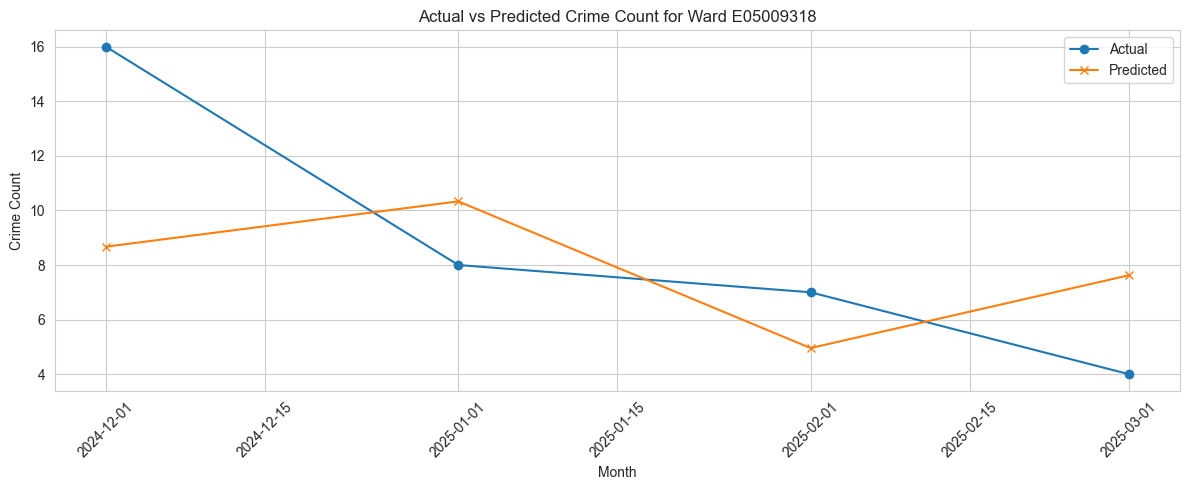

In [283]:
# PLOT TRUE VS PREDICTED CRIME COUNTS FOR EXAMPLE WARD 
test_df = test_df.copy()
test_df["prediction"] = final_model_all.predict(test_df[feature_cols])

# Pick a specific ward to visualize

ward_to_plot = test_df["Ward code"].unique()[1]  # replace with preferred ward if needed
ward_df = test_df[test_df["Ward code"] == ward_to_plot].sort_values("Month")

plt.figure(figsize=(12, 5))
plt.plot(ward_df["Month"], ward_df["Crime count"], label="Actual", marker='o')
plt.plot(ward_df["Month"], ward_df["prediction"], label="Predicted", marker='x')
plt.title(f"Actual vs Predicted Crime Count for Ward {ward_to_plot}")
plt.xlabel("Month")
plt.ylabel("Crime Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**HYPERPARAMETER TUNING FOR BEST MODEL UNTIL NOW**

**FEATURE IMPORTANCE / SHAP**